In [1]:
import numpy as np
from scipy import sparse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.evaluate import bias_variance_decomp
import re
from nltk.corpus import stopwords
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split 
from sklearn import metrics
from nltk.corpus import wordnet
from nltk.tokenize import wordpunct_tokenize
from sklearn import svm
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
import nltk
from nltk.corpus import stopwords
from sklearn import metrics
import itertools

In [2]:
news_dataset = pd.read_csv("train.csv")

## Choosing Features

We will in missing author values with the most frequent author in the dataset

In [3]:
news_dataset['author'] = news_dataset['author'].fillna("Pam Key")

#### Next step is to create new feature out of the existing features.

### Feature 1: word count

In [4]:
news_dataset['word_count'] = news_dataset['text'].apply(lambda x: len(str(x).split())) 

### Feature 2: average word length in <u>text</u>

In [5]:
news_dataset["text"] = news_dataset["text"].fillna('')
news_dataset['Avg_length'] = news_dataset["text"].apply(lambda x: np.mean([len(w) for w in x.split()]))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


### Feature 3: average word length in <u>title</u>

In [6]:
news_dataset["title"] = news_dataset["title"].fillna('')
news_dataset['title_avg_length'] = news_dataset["title"].apply(lambda x: np.mean([len(w) for w in x.split()]))

### Checking out the correlation between features

<AxesSubplot:>

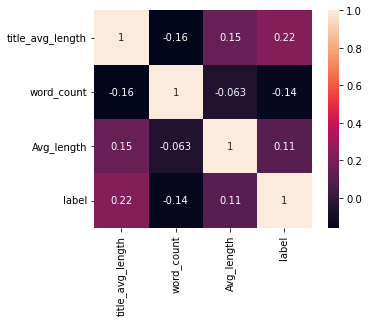

In [7]:
cols = ['title_avg_length', 'word_count', 'Avg_length', 'label']
corrmat = news_dataset[cols].corr()
sns.heatmap(corrmat, square=True, annot=True)

### We also take author as a feature because most frequent authors have a big contrast with fake and real news

In [8]:
news_dataset['author']
n = 10
authors = news_dataset['author'].value_counts()[:n].index.tolist()

authorsTable = pd.DataFrame()
real_articles = []
fake_articles = []

for author in authors:     
    fake_articles.append(len(news_dataset.loc[(news_dataset['author'] == author) & (news_dataset['label'] == 1)]))
    real_articles.append(len(news_dataset.loc[(news_dataset['author'] == author) & (news_dataset['label'] == 0)]))

authorsTable["author"] = authors
authorsTable["fake_articles"] = fake_articles
authorsTable["real_articles"] = real_articles

authorsTable

,author,fake_articles,real_articles
0,Pam Key,1932,268
1,admin,193,0
2,Jerome Hudson,0,166
3,Charlie Spiering,0,141
4,John Hayward,0,140
5,Katherine Rodriguez,0,124
6,Warner Todd Huston,0,122
7,Ian Hanchett,0,119
8,Breitbart News,0,118
9,Daniel Nussbaum,0,112


In [9]:
def confusionMatrix(prediction, modelName):
    cm = metrics.confusion_matrix(test_labels, prediction)

    plt.figure(figsize=(6, 6)) 

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
    plt.title('Confusion matrix ' + modelName)
    plt.colorbar()

    plt.xticks(np.arange(len(['Fake', 'Real'])), ['Fake', 'Real'], rotation=45)
    plt.yticks(np.arange(len(['Fake', 'Real'])), ['Fake', 'Real'])

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## Text Preprocessing
### title + author + text

In [10]:
nltk.download('stopwords') 
nltk.download('wordnet')
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/emabaranauskaite/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/emabaranauskaite/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:
lemmatizer = WordNetLemmatizer()

def preprocess(text, lowercase, removeURL, removeStopwords, lemmatize):
    if lowercase:
        text = text.lower()
                 
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) 
    
    if removeURL:
        text = re.sub('https?://\S+|www\.\S+', '', text)
        
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text) 
    
    text = text.split(' ') 
    
    if removeStopwords:
        filtered_sentence = []

        for w in text:
            if w.lower() not in stop_words and len(w) > 2:
                filtered_sentence.append(w)

        text = filtered_sentence
        
    if lemmatize:
        text = ' '.join([lemmatizer.lemmatize(w) for w in text])
    else:
        text = ' '.join(text)
     
    return text

In [12]:
news_dataset["title"] = news_dataset["title"].fillna('') 
news_dataset["article"] = news_dataset["title"] +  " " + news_dataset["author"] +  " " + news_dataset["text"]

articles = []

### 1. Text Processing: removing punctuation

In [13]:
processedText = []
for i in range(0, len(news_dataset)):
    text = preprocess(news_dataset.iloc[i]["article"], lowercase = False, removeURL = False, removeStopwords = False, lemmatize = False)
    processedText.append(text)
articles.append(processedText)

### 2. Text Processing: removing punctuation + lemmatization

In [14]:
processedText = []
for i in range(0, len(news_dataset)):
    text = preprocess(news_dataset.iloc[i]["article"], lowercase = False, removeURL = False, removeStopwords = False, lemmatize = True)
    processedText.append(text)
articles.append(processedText)

### 3. Text Processing: removing punctuation + removing stop words

In [15]:
processedText = []
for i in range(0, len(news_dataset)):
    text = preprocess(news_dataset.iloc[i]["article"], lowercase = False, removeURL = False, removeStopwords = True, lemmatize = False)
    processedText.append(text)
articles.append(processedText)

### 4. Text Processing: removing punctuation + removing URL

In [16]:
processedText = []
for i in range(0, len(news_dataset)):
    text = preprocess(news_dataset.iloc[i]["article"], lowercase = False, removeURL = True, removeStopwords = False, lemmatize = False)
    processedText.append(text)
articles.append(processedText)

### 5. Text Processing: removing punctuation + lowercase

In [17]:
processedText = []
for i in range(0, len(news_dataset)):
    text = preprocess(news_dataset.iloc[i]["article"], lowercase = True, removeURL = False, removeStopwords = False, lemmatize = False)
    processedText.append(text)
articles.append(processedText)

## Support Vector Machine

In [18]:
modelType = {}

### 1. Text Processing: removing punctuation

In [19]:
news_dataset[["title_avg_length", "Avg_length"]] = news_dataset[["title_avg_length", "Avg_length"]].fillna(0)
word_count_avg_length = news_dataset[["title_avg_length", "Avg_length"]].values
article = articles[0]
labels = news_dataset['label'].values

# Splitting into train and test sets
train_info, test_info, train_article, test_article, train_labels, test_labels = train_test_split(word_count_avg_length, article, labels, test_size=0.2)

### TF-IDF 1-gram

In [20]:
# TF-IDF creating numeric values for text
vectorization = TfidfVectorizer(ngram_range=(1,1))
train_article_1Gram = vectorization.fit_transform(train_article)
test_article_1Gram = vectorization.transform(test_article)

# Combining all features into one sparse matrix
train_data_1Gram = sparse.hstack([train_article_1Gram, train_info])
test_data_1Gram = sparse.hstack([test_article_1Gram, test_info])

In [21]:
# Training
SVM = svm.SVC()
SVM.fit(train_data_1Gram, train_labels)
predictionSVM = SVM.predict(test_data_1Gram) 

# Classifier score - TF-IDF 1 grams
score = SVM.score(test_data_1Gram, test_labels)
modelType["1-gram", "Text Processing: removing punctuation"] = [score, predictionSVM]

print("Accuracy with TF-IDF 1-gram:", score)

Accuracy with TF-IDF 1-gram: 0.9158653846153846


### TF-IDF 2-gram

In [22]:
# TF-IDF creating numeric values for text
vectorization = TfidfVectorizer(ngram_range=(2,2))
train_article_2Gram = vectorization.fit_transform(train_article)
test_article_2Gram = vectorization.transform(test_article)

# Combining all features into one sparse matrix
train_data_2Gram = sparse.hstack([train_article_2Gram, train_info])
test_data_2Gram = sparse.hstack([test_article_2Gram, test_info])

In [23]:
# Training
SVM = svm.SVC()
SVM.fit(train_data_2Gram, train_labels)
predictionSVM = SVM.predict(test_data_2Gram) 

# Classifier score - TF-IDF 2 grams
score = SVM.score(test_data_2Gram, test_labels)
modelType["2-grams", "Text Processing: removing punctuation"] = [score, predictionSVM]

print("Accuracy with TF-IDF 2-gram:", SVM.score(test_data_2Gram, test_labels))

Accuracy with TF-IDF 2-gram: 0.7677884615384616


### TF-IDF 3-gram

In [24]:
# TF-IDF creating numeric values for text
vectorization = TfidfVectorizer(ngram_range=(3,3))
train_article_3Gram = vectorization.fit_transform(train_article)
test_article_3Gram = vectorization.transform(test_article)

# Combining all features into one sparse matrix
train_data_3Gram = sparse.hstack([train_article_3Gram, train_info])
test_data_3Gram = sparse.hstack([test_article_3Gram, test_info])

In [25]:
# Training
SVM = svm.SVC()
SVM.fit(train_data_3Gram, train_labels)
predictionSVM = SVM.predict(test_data_3Gram) 

# Classifier score - TF-IDF 3 grams
score = SVM.score(test_data_3Gram, test_labels)
modelType["3-grams", "Text Processing: removing punctuation"] = [score, predictionSVM]

print("Accuracy with TF-IDF 3-gram:", SVM.score(test_data_3Gram, test_labels))

Accuracy with TF-IDF 3-gram: 0.6764423076923077


### 2. Text Processing: removing punctuation + lemmatization

In [26]:
news_dataset[["title_avg_length", "Avg_length"]] = news_dataset[["title_avg_length", "Avg_length"]].fillna(0)
word_count_avg_length = news_dataset[["title_avg_length", "Avg_length"]].values
article = articles[1]
labels = news_dataset['label'].values

# Splitting into train and test sets
train_info, test_info, train_article, test_article, train_labels, test_labels = train_test_split(word_count_avg_length, article, labels, test_size=0.2)

### TF-IDF 1-gram

In [27]:
# TF-IDF creating numeric values for text
vectorization = TfidfVectorizer(ngram_range=(1,1))
train_article_1Gram = vectorization.fit_transform(train_article)
test_article_1Gram = vectorization.transform(test_article)

# Combining all features into one sparse matrix
train_data_1Gram = sparse.hstack([train_article_1Gram, train_info])
test_data_1Gram = sparse.hstack([test_article_1Gram, test_info])

In [28]:
# Training
SVM = svm.SVC()
SVM.fit(train_data_1Gram, train_labels)
predictionSVM = SVM.predict(test_data_1Gram) 

# Classifier score - TF-IDF 1 grams
score = SVM.score(test_data_1Gram, test_labels)
modelType["1-gram", "Text Processing: removing punctuation + lemmatization"] = [score, predictionSVM]

print("Accuracy with TF-IDF 1-gram:", score)

Accuracy with TF-IDF 1-gram: 0.9100961538461538


### TF-IDF 2-gram

In [29]:
# TF-IDF creating numeric values for text
vectorization = TfidfVectorizer(ngram_range=(2,2))
train_article_2Gram = vectorization.fit_transform(train_article)
test_article_2Gram = vectorization.transform(test_article)

# Combining all features into one sparse matrix
train_data_2Gram = sparse.hstack([train_article_2Gram, train_info])
test_data_2Gram = sparse.hstack([test_article_2Gram, test_info])

In [30]:
# Training
SVM = svm.SVC()
SVM.fit(train_data_2Gram, train_labels)
predictionSVM = SVM.predict(test_data_2Gram) 

# Classifier score - TF-IDF 2 grams
score = SVM.score(test_data_2Gram, test_labels)
modelType["2-grams", "Text Processing: removing punctuation"] = [score, predictionSVM]

print("Accuracy with TF-IDF 2-gram:", SVM.score(test_data_2Gram, test_labels))

Accuracy with TF-IDF 2-gram: 0.7591346153846154


### TF-IDF 3-gram

In [31]:
# TF-IDF creating numeric values for text
vectorization = TfidfVectorizer(ngram_range=(3,3))
train_article_3Gram = vectorization.fit_transform(train_article)
test_article_3Gram = vectorization.transform(test_article)

# Combining all features into one sparse matrix
train_data_3Gram = sparse.hstack([train_article_3Gram, train_info])
test_data_3Gram = sparse.hstack([test_article_3Gram, test_info])

In [32]:
# Training
SVM = svm.SVC()
SVM.fit(train_data_3Gram, train_labels)
predictionSVM = SVM.predict(test_data_3Gram) 

# Classifier score - TF-IDF 3 grams
score = SVM.score(test_data_3Gram, test_labels)
modelType["3-grams", "Text Processing: removing punctuation"] = [score, predictionSVM]

print("Accuracy with TF-IDF 3-gram:", SVM.score(test_data_3Gram, test_labels))

Accuracy with TF-IDF 3-gram: 0.6723557692307692


### 3. Text Processing: removing punctuation + removing stop words

In [33]:
news_dataset[["title_avg_length", "Avg_length"]] = news_dataset[["title_avg_length", "Avg_length"]].fillna(0)
word_count_avg_length = news_dataset[["title_avg_length", "Avg_length"]].values
article = articles[2]
labels = news_dataset['label'].values

# Splitting into train and test sets
train_info, test_info, train_article, test_article, train_labels, test_labels = train_test_split(word_count_avg_length, article, labels, test_size=0.2)

### TF-IDF 1-gram

In [34]:
# TF-IDF creating numeric values for text
vectorization = TfidfVectorizer(ngram_range=(1,1))
train_article_1Gram = vectorization.fit_transform(train_article)
test_article_1Gram = vectorization.transform(test_article)

# Combining all features into one sparse matrix
train_data_1Gram = sparse.hstack([train_article_1Gram, train_info])
test_data_1Gram = sparse.hstack([test_article_1Gram, test_info])

In [35]:
# Training
SVM = svm.SVC()
SVM.fit(train_data_1Gram, train_labels)
predictionSVM = SVM.predict(test_data_1Gram) 

# Classifier score - TF-IDF 1 grams
score = SVM.score(test_data_1Gram, test_labels)
modelType["1-gram", "Text Processing: removing punctuation"] = [score, predictionSVM]

print("Accuracy with TF-IDF 1-gram:", score)

Accuracy with TF-IDF 1-gram: 0.8935096153846154


### TF-IDF 2-gram

In [36]:
# TF-IDF creating numeric values for text
vectorization = TfidfVectorizer(ngram_range=(2,2))
train_article_2Gram = vectorization.fit_transform(train_article)
test_article_2Gram = vectorization.transform(test_article)

# Combining all features into one sparse matrix
train_data_2Gram = sparse.hstack([train_article_2Gram, train_info])
test_data_2Gram = sparse.hstack([test_article_2Gram, test_info])

In [37]:
# Training
SVM = svm.SVC()
SVM.fit(train_data_2Gram, train_labels)
predictionSVM = SVM.predict(test_data_2Gram) 

# Classifier score - TF-IDF 2 grams
score = SVM.score(test_data_2Gram, test_labels)
modelType["2-grams", "Text Processing: removing punctuation + removing stop words"] = [score, predictionSVM]

print("Accuracy with TF-IDF 2-gram:", SVM.score(test_data_2Gram, test_labels))

Accuracy with TF-IDF 2-gram: 0.6802884615384616


### TF-IDF 3-gram

In [38]:
# TF-IDF creating numeric values for text
vectorization = TfidfVectorizer(ngram_range=(3,3))
train_article_3Gram = vectorization.fit_transform(train_article)
test_article_3Gram = vectorization.transform(test_article)

# Combining all features into one sparse matrix
train_data_3Gram = sparse.hstack([train_article_3Gram, train_info])
test_data_3Gram = sparse.hstack([test_article_3Gram, test_info])

In [39]:
# Training
SVM = svm.SVC()
SVM.fit(train_data_3Gram, train_labels)
predictionSVM = SVM.predict(test_data_3Gram) 

# Classifier score - TF-IDF 3 grams
score = SVM.score(test_data_3Gram, test_labels)
modelType["3-grams", "Text Processing: removing punctuation"] = [score, predictionSVM]

print("Accuracy with TF-IDF 3-gram:", SVM.score(test_data_3Gram, test_labels))

Accuracy with TF-IDF 3-gram: 0.6463942307692307


### 4. Text Processing: removing punctuation + removing URL

In [40]:
news_dataset[["title_avg_length", "Avg_length"]] = news_dataset[["title_avg_length", "Avg_length"]].fillna(0)
word_count_avg_length = news_dataset[["title_avg_length", "Avg_length"]].values
article = articles[3]
labels = news_dataset['label'].values

# Splitting into train and test sets
train_info, test_info, train_article, test_article, train_labels, test_labels = train_test_split(word_count_avg_length, article, labels, test_size=0.2)

### TF-IDF 1-gram

In [41]:
# TF-IDF creating numeric values for text
vectorization = TfidfVectorizer(ngram_range=(1,1))
train_article_1Gram = vectorization.fit_transform(train_article)
test_article_1Gram = vectorization.transform(test_article)

# Combining all features into one sparse matrix
train_data_1Gram = sparse.hstack([train_article_1Gram, train_info])
test_data_1Gram = sparse.hstack([test_article_1Gram, test_info])

In [42]:
# Training
SVM = svm.SVC()
SVM.fit(train_data_1Gram, train_labels)
predictionSVM = SVM.predict(test_data_1Gram) 

# Classifier score - TF-IDF 1 grams
score = SVM.score(test_data_1Gram, test_labels)
modelType["1-gram", "Text Processing: removing punctuation"] = [score, predictionSVM]

print("Accuracy with TF-IDF 1-gram:", score)

Accuracy with TF-IDF 1-gram: 0.9137019230769231


### TF-IDF 2-gram

In [43]:
# TF-IDF creating numeric values for text
vectorization = TfidfVectorizer(ngram_range=(2,2))
train_article_2Gram = vectorization.fit_transform(train_article)
test_article_2Gram = vectorization.transform(test_article)

# Combining all features into one sparse matrix
train_data_2Gram = sparse.hstack([train_article_2Gram, train_info])
test_data_2Gram = sparse.hstack([test_article_2Gram, test_info])

In [44]:
# Training
SVM = svm.SVC()
SVM.fit(train_data_2Gram, train_labels)
predictionSVM = SVM.predict(test_data_2Gram) 

# Classifier score - TF-IDF 2 grams
score = SVM.score(test_data_2Gram, test_labels)
modelType["2-grams", "Text Processing: removing punctuation + removing URL"] = [score, predictionSVM]

print("Accuracy with TF-IDF 2-gram:", SVM.score(test_data_2Gram, test_labels))

Accuracy with TF-IDF 2-gram: 0.7403846153846154


### TF-IDF 3-gram

In [45]:
# TF-IDF creating numeric values for text
vectorization = TfidfVectorizer(ngram_range=(3,3))
train_article_3Gram = vectorization.fit_transform(train_article)
test_article_3Gram = vectorization.transform(test_article)

# Combining all features into one sparse matrix
train_data_3Gram = sparse.hstack([train_article_3Gram, train_info])
test_data_3Gram = sparse.hstack([test_article_3Gram, test_info])

In [46]:
# Training
SVM = svm.SVC()
SVM.fit(train_data_3Gram, train_labels)
predictionSVM = SVM.predict(test_data_3Gram) 

# Classifier score - TF-IDF 3 grams
score = SVM.score(test_data_3Gram, test_labels)
modelType["3-grams", "Text Processing: removing punctuation"] = [score, predictionSVM]

print("Accuracy with TF-IDF 3-gram:", SVM.score(test_data_3Gram, test_labels))

Accuracy with TF-IDF 3-gram: 0.661298076923077


### 5. Text Processing: removing punctuation + lowercase

In [47]:
news_dataset[["title_avg_length", "Avg_length"]] = news_dataset[["title_avg_length", "Avg_length"]].fillna(0)
word_count_avg_length = news_dataset[["title_avg_length", "Avg_length"]].values
article = articles[4]
labels = news_dataset['label'].values

# Splitting into train and test sets
train_info, test_info, train_article, test_article, train_labels, test_labels = train_test_split(word_count_avg_length, article, labels, test_size=0.2)

### TF-IDF 1-gram

In [48]:
# TF-IDF creating numeric values for text
vectorization = TfidfVectorizer(ngram_range=(1,1))
train_article_1Gram = vectorization.fit_transform(train_article)
test_article_1Gram = vectorization.transform(test_article)

# Combining all features into one sparse matrix
train_data_1Gram = sparse.hstack([train_article_1Gram, train_info])
test_data_1Gram = sparse.hstack([test_article_1Gram, test_info])

In [49]:
# Training
SVM = svm.SVC()
SVM.fit(train_data_1Gram, train_labels)
predictionSVM = SVM.predict(test_data_1Gram) 

# Classifier score - TF-IDF 1 grams
score = SVM.score(test_data_1Gram, test_labels)
modelType["1-gram", "Text Processing: removing punctuation"] = [score, predictionSVM]

print("Accuracy with TF-IDF 1-gram:", score)

Accuracy with TF-IDF 1-gram: 0.9141826923076923


### TF-IDF 2-gram

In [50]:
# TF-IDF creating numeric values for text
vectorization = TfidfVectorizer(ngram_range=(2,2))
train_article_2Gram = vectorization.fit_transform(train_article)
test_article_2Gram = vectorization.transform(test_article)

# Combining all features into one sparse matrix
train_data_2Gram = sparse.hstack([train_article_2Gram, train_info])
test_data_2Gram = sparse.hstack([test_article_2Gram, test_info])

In [51]:
# Training
SVM = svm.SVC()
SVM.fit(train_data_2Gram, train_labels)
predictionSVM = SVM.predict(test_data_2Gram) 

# Classifier score - TF-IDF 2 grams
score = SVM.score(test_data_2Gram, test_labels)
modelType["2-grams", "Text Processing: removing punctuation + lowercase"] = [score, predictionSVM]

print("Accuracy with TF-IDF 2-gram:", SVM.score(test_data_2Gram, test_labels))

Accuracy with TF-IDF 2-gram: 0.7512019230769231


### TF-IDF 3-gram

In [52]:
# TF-IDF creating numeric values for text
vectorization = TfidfVectorizer(ngram_range=(3,3))
train_article_3Gram = vectorization.fit_transform(train_article)
test_article_3Gram = vectorization.transform(test_article)

# Combining all features into one sparse matrix
train_data_3Gram = sparse.hstack([train_article_3Gram, train_info])
test_data_3Gram = sparse.hstack([test_article_3Gram, test_info])

In [53]:
# Training
SVM = svm.SVC()
SVM.fit(train_data_3Gram, train_labels)
predictionSVM = SVM.predict(test_data_3Gram) 

# Classifier score - TF-IDF 3 grams
score = SVM.score(test_data_3Gram, test_labels)
modelType["3-grams", "Text Processing: removing punctuation"] = [score, predictionSVM]

print("Accuracy with TF-IDF 3-gram:", SVM.score(test_data_3Gram, test_labels))

Accuracy with TF-IDF 3-gram: 0.6596153846153846


### 6. No text processing

In [54]:
news_dataset[["title_avg_length", "Avg_length"]] = news_dataset[["title_avg_length", "Avg_length"]].fillna(0)
word_count_avg_length = news_dataset[["title_avg_length", "Avg_length"]].values
article = news_dataset["article"].values
labels = news_dataset['label'].values

# Splitting into train and test sets
train_info, test_info, train_article, test_article, train_labels, test_labels = train_test_split(word_count_avg_length, article, labels, test_size=0.2)

### TF-IDF 1-gram

In [55]:
# TF-IDF creating numeric values for text
vectorization = TfidfVectorizer(ngram_range=(1,1))
train_article_1Gram = vectorization.fit_transform(train_article)
test_article_1Gram = vectorization.transform(test_article)

# Combining all features into one sparse matrix
train_data_1Gram = sparse.hstack([train_article_1Gram, train_info])
test_data_1Gram = sparse.hstack([test_article_1Gram, test_info])

In [56]:
# Training
SVM = svm.SVC()
SVM.fit(train_data_1Gram, train_labels)
predictionSVM = SVM.predict(test_data_1Gram) 

# Classifier score - TF-IDF 1 grams
score = SVM.score(test_data_1Gram, test_labels)
modelType["1-gram", "No Text Processing"] = [score, predictionSVM]

print("Accuracy with TF-IDF 1-gram:", score)

Accuracy with TF-IDF 1-gram: 0.9221153846153847


### TF-IDF 2-gram

In [57]:
# TF-IDF creating numeric values for text
vectorization = TfidfVectorizer(ngram_range=(2,2))
train_article_2Gram = vectorization.fit_transform(train_article)
test_article_2Gram = vectorization.transform(test_article)

# Combining all features into one sparse matrix
train_data_2Gram = sparse.hstack([train_article_2Gram, train_info])
test_data_2Gram = sparse.hstack([test_article_2Gram, test_info])

In [58]:
# Training
SVM = svm.SVC()
SVM.fit(train_data_2Gram, train_labels)
predictionSVM = SVM.predict(test_data_2Gram) 

# Classifier score - TF-IDF 2 grams
score = SVM.score(test_data_2Gram, test_labels)
modelType["2-grams", "Text Processing: removing punctuation"] = [score, predictionSVM]

print("Accuracy with TF-IDF 2-gram:", SVM.score(test_data_2Gram, test_labels))

Accuracy with TF-IDF 2-gram: 0.7764423076923077


### TF-IDF 3-gram

In [59]:
# TF-IDF creating numeric values for text
vectorization = TfidfVectorizer(ngram_range=(3,3))
train_article_3Gram = vectorization.fit_transform(train_article)
test_article_3Gram = vectorization.transform(test_article)

# Combining all features into one sparse matrix
train_data_3Gram = sparse.hstack([train_article_3Gram, train_info])
test_data_3Gram = sparse.hstack([test_article_3Gram, test_info])

In [60]:
# Training
SVM = svm.SVC()
SVM.fit(train_data_3Gram, train_labels)
predictionSVM = SVM.predict(test_data_3Gram) 

# Classifier score - TF-IDF 3 grams
score = SVM.score(test_data_3Gram, test_labels)
modelType["3-grams", "Text Processing: removing punctuation"] = [score, predictionSVM]

print("Accuracy with TF-IDF 3-gram:", SVM.score(test_data_3Gram, test_labels))

Accuracy with TF-IDF 3-gram: 0.6848557692307692


## Best Result

In [61]:
bestSVMmodel = max(modelType, key=modelType.get)
print("The highest accuracy scored a support vector machine model with", bestSVMmodel[1], "and TF-IDF", bestSVMmodel[0], "value")
print("The accuracy is:", modelType[bestSVMmodel])

The highest accuracy scored a support vector machine model with No Text Processing and TF-IDF 1-gram value
The accuracy is: [0.9221153846153847, array([0, 0, 0, ..., 1, 1, 0])]


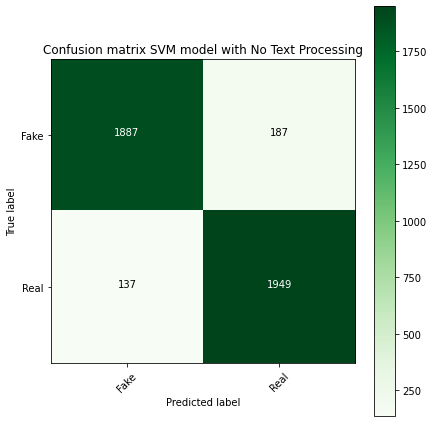

In [62]:
prediction = modelType[bestSVMmodel][1]
modelName = "SVM model with " + bestSVMmodel[1]

confusionMatrix(prediction, modelName)